# Use Log Exploration / Unsupervised Learning

In [1]:
import numpy as np
import pandas as pd

import data_manipulation as dm
import time
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#memb = dm.members()
#txn= dm.transactions()
train = dm.train()
ul = dm.user_logs()

In [3]:
ul = ul.sort_values(['new_id','date']) #sorting algorithms keep being a b*&#%

In [4]:
"""
Getting a sense of the user_log data:

ul[ul['total_secs']<0].head()
ul['total_secs'].describe()
ul['num_25'].describe()
ul['num_50'].describe()
ul['num_75'].describe()
ul['num_985'].describe()
ul['num_100'].describe()
ul['num_unq'].describe()

print ('total nulls for total_secs: %s' %(len(ul[pd.isnull(ul['total_secs'])==True])))
print ('total nulls for num_25: %s' %(len(ul[pd.isnull(ul['num_25'])==True])))
print ('total nulls for num_50: %s' %(len(ul[pd.isnull(ul['num_50'])==True])))
print ('total nulls for num_75: %s' %(len(ul[pd.isnull(ul['num_75'])==True])))
print ('total nulls for num_985: %s' %(len(ul[pd.isnull(ul['num_985'])==True])))
print ('total nulls for num_100: %s' %(len(ul[pd.isnull(ul['num_100'])==True])))
print ('total nulls for num_unq: %s' %(len(ul[pd.isnull(ul['num_unq'])==True])))

ul['total_secs'].quantile(0.985)

ul['secs_capped'] = ul['total_secs'].clip(lower = 0, upper = ul['total_secs'].quantile(0.985))
ul['secs_capped'].describe()
sns.boxplot(ul['secs_capped'], color='green')
""";

## Feature Engineering

- **total months listening**: total months that a user listening at least once in the previous 25 months
- **listening_p12**: number of months in previous 12 where user listened at least once
- **no_songs_cp6**: number of consecutive months (from Jan 31st) without listening data in previous 6 months
- **logavg_secs_p12**: log transformation of monthly average total seconds for previous 12 months
- **freq_days**: median time (days) user waits to listen to songs in KKBox


<table>
<th>new id</th>
<th>total months listening</th>
<th>listening_p12</th>
<th>no_songs_cp6</th>
<th>logavg_secs_p12</th>
<th>freq_days</th>
<tr>
    <td>integer </td>
    <td>categorical[5]</td>
    <td>discrete[0-12]</td>
    <td>discrete[0-6]</td>
    <td>continuous</td>
    <td>continuous</td>
</tr>
</table>

<br></br>

In [5]:
#create freq_days variable (thanks Cathy)
ul['previous_date'] = ul.groupby('new_id')['date'].shift()
ul['time_lapsed'] = (ul['date'] - ul['previous_date']).astype('timedelta64[D]')
ul_freq = ul.groupby('new_id')['time_lapsed'].median().reset_index(name='freq_days')
print (ul_freq.shape)
ul_freq.head()

(950184, 2)


,new_id,freq_days
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0


In [6]:
#estimate total number of songs and recalculate total_secs for outliers
ul['total_songs']=(0.25*ul['num_25'] + 0.50*ul['num_50'] + 0.75*ul['num_75'] + 0.985*ul['num_985']+ul['num_100'])
ul['total_songs'] = ul['total_songs'].clip(lower = 0, upper = ul['total_songs'].quantile(0.995))

compensation_factor = 1.0

ul['avg_song'] = ul['total_secs']/(((0.25*ul['num_25'] + 0.50*ul['num_50'] + 0.75*ul['num_75'] + 0.985*ul['num_985'])*compensation_factor)+ul['num_100'])
avg_song = ul['avg_song'].quantile(0.5) #median

#masked_secs = ul.total_secs <= 0 | ul.total_secs > ul['total_secs'].quantile(0.985)
#column_name = 'total_secs'
#ul.loc[masked_secs, column_name] = ul.loc[masked_secs, 'total_songs']*avg_song

In [7]:
mask_lower = ul.total_secs <= 0
mask_upper = ul.total_secs > ul['total_secs'].quantile(0.985)
column_name = 'total_secs'
ul.loc[mask_lower, column_name] = ul.loc[mask_lower, 'total_songs']*avg_song
ul.loc[mask_upper, column_name] = ul.loc[mask_upper, 'total_songs']*avg_song

In [8]:
#add a yearMonth variable to aggregate by month
ul['yearMonth'] = pd.DatetimeIndex(ul['date']).year*100+pd.DatetimeIndex(ul['date']).month

In [51]:
#add total months with listening data
sum_months = pd.pivot_table(ul, values='total_secs', index=['new_id'], columns=['yearMonth'], aggfunc=np.sum)

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


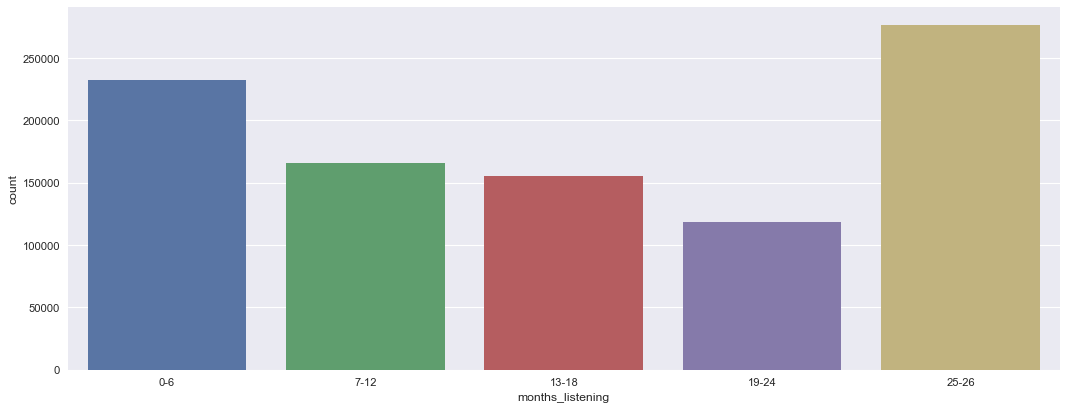

In [52]:
sum_months['months_listening'] = pd.cut(np.count_nonzero(sum_months.fillna(0).drop(201702,axis=1), axis = 1)
                                        , [0,6,12,18,24,30]
                                        , labels=['0-6','7-12','13-18','19-24','25-26']).fillna('0-6')

#sum_months['months_listening'] = sum_months['months_listening'].fillna('0-6', inplace = True) 
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.countplot(sum_months['months_listening']);

In [53]:
#sum_months.fillna('0-6', inplace=True)
len(sum_months[pd.isnull(sum_months['months_listening'])==True])

0

In [54]:
#add months with listening data for previous 6 months (p6), 12 months (p12)
p6 = [201701,201612,201611,201610,201609,201608]
p12 = [201701,201612,201611,201610,201609,201608,201607,201606,201605,201604,201603,201602]

sum_months['listening_p6'] = np.count_nonzero(sum_months[p6].fillna(0), axis = 1)
sum_months['listening_p12'] = np.count_nonzero(sum_months[p12].fillna(0), axis = 1)

#add log of monthly average
sum_months['logavg_secs_p12'] = np.log((np.sum(sum_months[p12].fillna(0), axis = 1)+1)/(sum_months['listening_p12']+1))

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


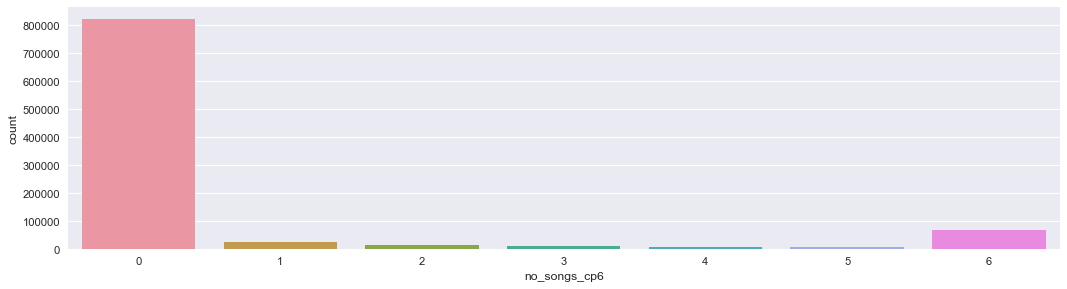

In [55]:
##create variable of previous consecutive months with no listening data
no_songs = []
for id in np.unique(sum_months.index.values):
    total_months = 0
    if np.isnan(sum_months.loc[id, 201701]):
        total_months += 1
        if np.isnan(sum_months.loc[id, 201612]):
            total_months += 1
            if np.isnan(sum_months.loc[id, 201611]):
                total_months += 1
                if np.isnan(sum_months.loc[id, 201610]):
                    total_months += 1
                    if np.isnan(sum_months.loc[id, 201609]):
                        total_months += 1
                        if np.isnan(sum_months.loc[id, 201608]):
                            total_months += 1
    no_songs.append(total_months)

sum_months['no_songs_cp6'] = no_songs

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.countplot(sum_months['no_songs_cp6'])

In [56]:
f_ul = train.merge(sum_months.reset_index(), left_on='new_id', right_on='new_id', how='left', copy = False)[
    ['new_id','is_churn','no_songs_cp6','months_listening','listening_p6','listening_p12','logavg_secs_p12']
    ].merge(ul_freq, left_on = 'new_id', right_on = 'new_id', how='left', copy=False)

f_ul.shape

(992931, 8)

In [60]:
f_ul.to_csv('final_user_log.csv', index = False)

In [64]:
len(train)-np.sum(train['new_id'].isin(ul['new_id']))

,new_id,is_churn,no_songs_cp6,months_listening,listening_p6,listening_p12,logavg_secs_p12,freq_days
0,1025093,1,0.0,0-6,2.0,2.0,10.333973,1.0
1,476532,1,1.0,19-24,5.0,11.0,10.487334,1.0
2,731853,1,0.0,7-12,6.0,12.0,12.205067,1.0
3,854199,1,0.0,25-26,6.0,12.0,12.329552,1.0
4,601853,1,0.0,25-26,6.0,12.0,13.448430,1.0


/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


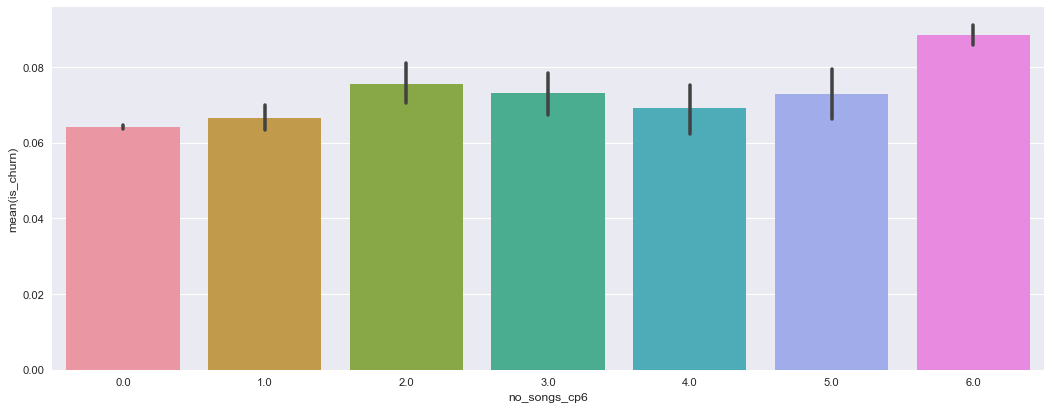

In [18]:
#There seem to be an upward trend in churn based on the consecutive months without listening data. 
#It is not clear why the wave from 3-5 months without listening data. Are those filled with dormant users?
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('no_songs_cp6', 'is_churn', data=f_ul);

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


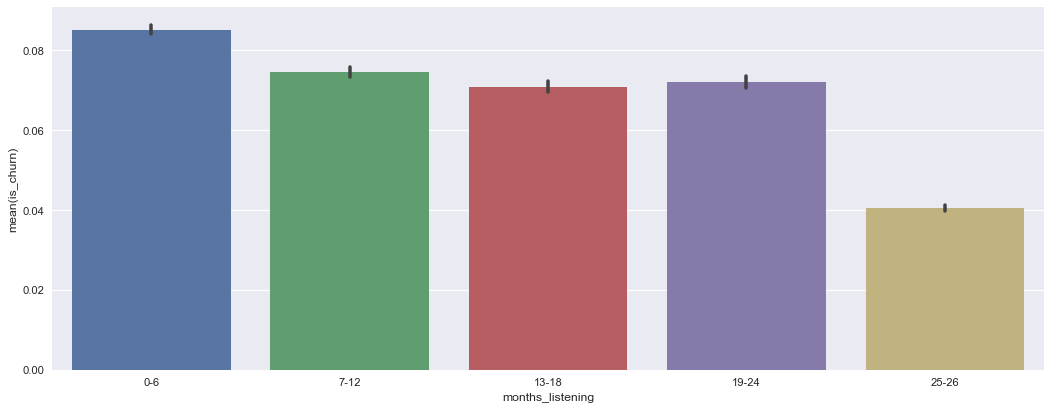

In [19]:
#It seems that users with 0-6 months of listening data are more likely to churn than long-term users
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('months_listening', 'is_churn', data=f_ul);

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


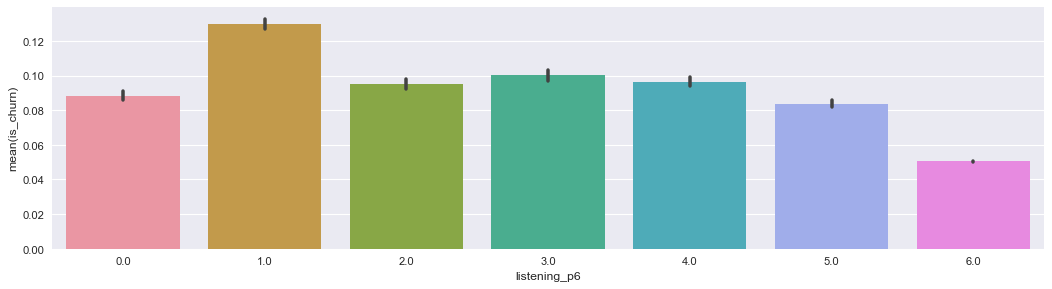

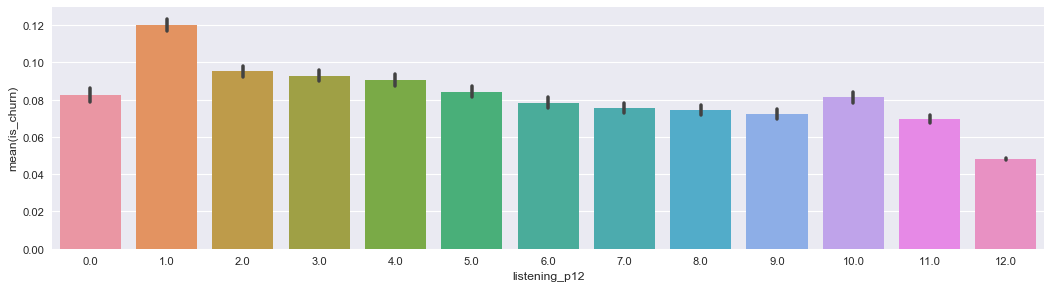

In [20]:
#Again, Users with less listening months seem to be more likely to churn
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('listening_p6', 'is_churn', data=f_ul);

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('listening_p12', 'is_churn', data=f_ul);

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:885: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:905: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


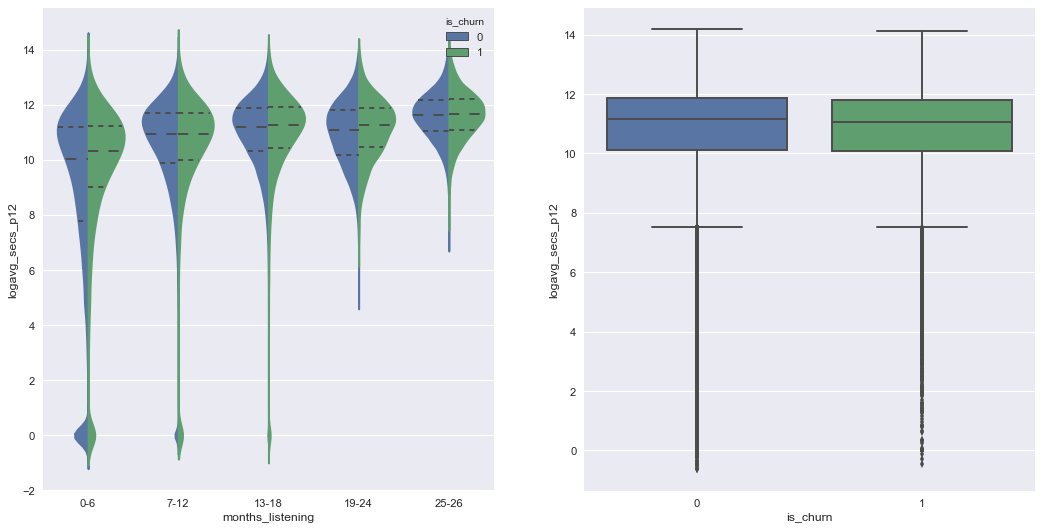

In [22]:
#Total seconds does not show any clear relationship with churn
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.violinplot( f_ul['months_listening'] , f_ul['logavg_secs_p12'], hue =f_ul['is_churn'] , split=True, inner="quartile");

plt.subplot(1,2,2)
sns.boxplot(  f_ul['is_churn'] , f_ul['logavg_secs_p12']);

In [23]:
#VARIABLES CREATED SO FAR (SOME HAVE NULL/NaN VALUES)
f_ul.head()

,new_id,is_churn,no_songs_cp6,months_listening,listening_p6,listening_p12,logavg_secs_p12,freq_days
0,1025093,1,0.0,0-6,2.0,2.0,10.333973,1.0
1,476532,1,1.0,19-24,5.0,11.0,10.487334,1.0
2,731853,1,0.0,7-12,6.0,12.0,12.205067,1.0
3,854199,1,0.0,25-26,6.0,12.0,12.329552,1.0
4,601853,1,0.0,25-26,6.0,12.0,13.448430,1.0


In [24]:
###maybe create an index for unique songs vs. total_songs as a measure of engagement?
munique_median = pd.pivot_table(ul, values='num_unq', index=['new_id'], columns=['yearMonth'], aggfunc=np.median)
msongs_median = pd.pivot_table(ul, values='total_songs', index=['new_id'], columns=['yearMonth'], aggfunc=np.median)

variety_songs = np.divide(munique_median, msongs_median)

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


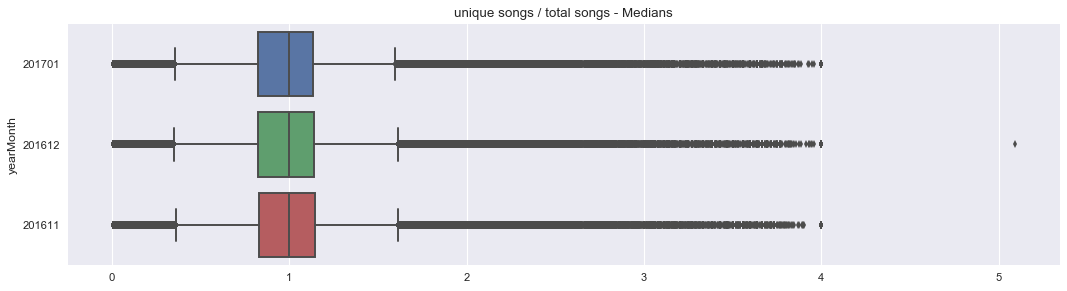

In [25]:
plt.figure(num=None, figsize=(16,4), dpi=80, facecolor='w', edgecolor='k')
plt.title('unique songs / total songs - Medians');
sns.boxplot(variety_songs[[201701,201612,201611]], orient='h')

In [26]:
## Test some clusters on median seconds monthly (need to fill NAs with 0s)
tmonths = pd.pivot_table(ul, values='total_secs', index=['new_id'], columns=['yearMonth'], aggfunc=np.median)
tmonths.fillna(0, inplace = True)

Clusters: 3


/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


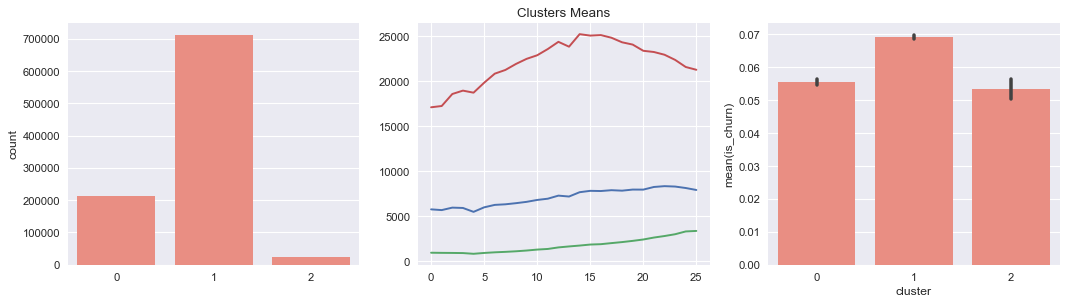

Clusters: 4


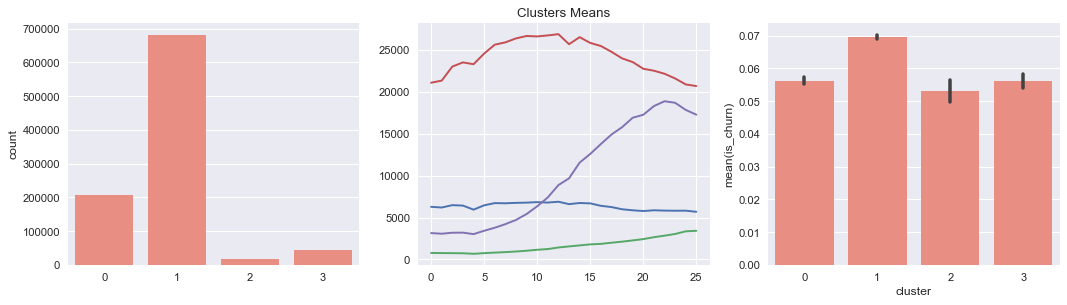

Clusters: 5


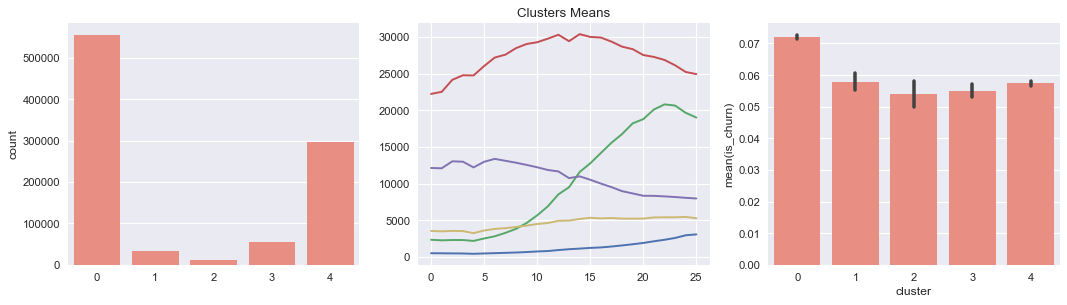

Clusters: 6


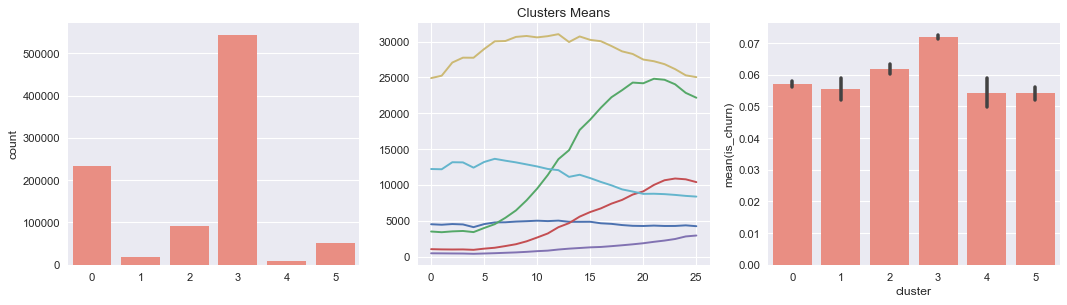

Clusters: 7


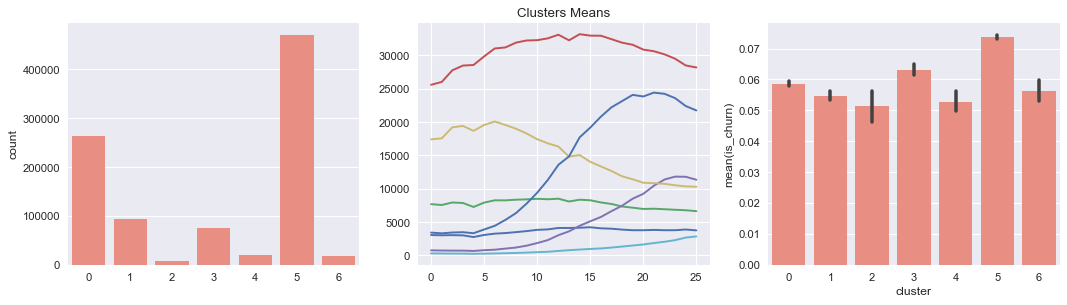

Clusters: 8


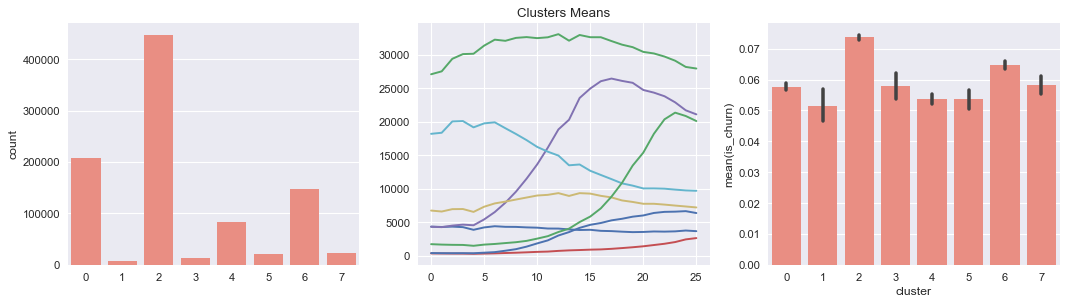

Clusters: 9


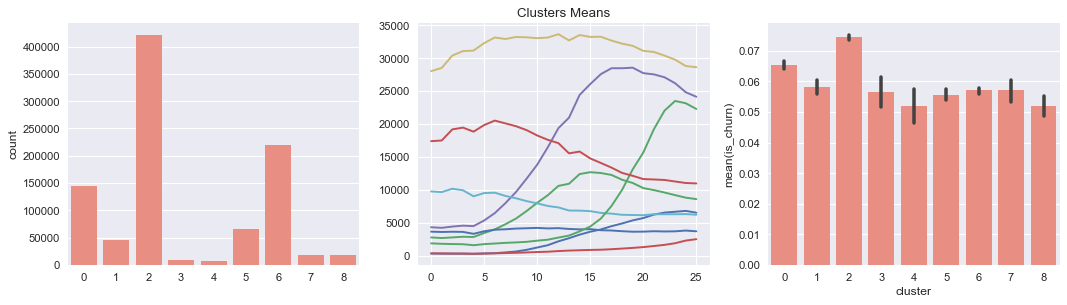

In [33]:
from sklearn.cluster import KMeans
sclusters = [3,4,5,6,7,8,9]
tmonths_temp = tmonths.copy(deep=True)

for scluster in sclusters:
    kmeans = KMeans(n_clusters=scluster, random_state=0).fit(tmonths)
    tmonths_temp['cluster'] = kmeans.labels_
    x_temp =  train.merge(tmonths_temp.reset_index(), left_on='new_id', right_on='new_id', how='inner', copy = False)[
    ['new_id','is_churn','cluster']]
    
    plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
    print ('Clusters: {}'.format(scluster))
    plt.subplot(1,3,1)
    sns.countplot(kmeans.labels_, color="salmon")

    plt.subplot(1,3,2)
    plt.title('Clusters Means')
    plt.plot(kmeans.cluster_centers_.T);
    
    plt.subplot(1,3,3)
    sns.barplot(x_temp['cluster'], x_temp['is_churn'], color="salmon")
    plt.show()

In [34]:
##try hierarchical clustering here(watch out on computing power needed)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = linkage(tmonths.head(10000), 'ward') #test other methods n distances too

#check the cophenetic coefficient of clusters (closer to 1 better)
ccc, coph_dists = cophenet(Z, pdist(tmonths.head(10000)))
ccc

0.58213013902613586

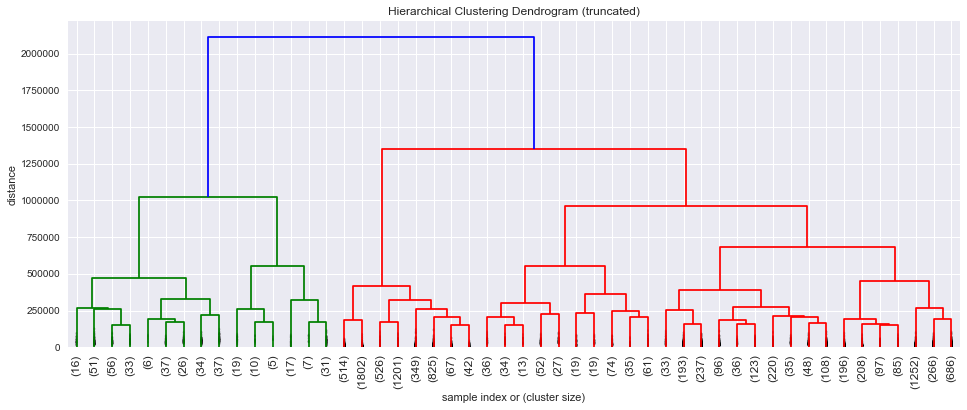

In [33]:
plt.figure(num=None, figsize=(16, 6))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
f_ul.to_csv('final_user_log.csv', index = False)

In [34]:
######################################## OLD CODE BELOW ########################################

## Monthly Median Seconds

In [ ]:
'''
#tmonths = pd.read_csv('../ul_tsecs_month_median.csv', index_col = 'new_id')
#tmonths.head()

#visualize time-pattern of random 1000 users

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
user_count = 1000
for i in range(user_count):
    x = tmonths.loc[np.random.choice(tmonths.index, 1), :].values.reshape(26,1)
    plt.plot(x, lw=0.5)
plt.xticks(range(26),tmonths.columns.values, rotation=70)
plt.title('Median daily secs monthly - Random {} Users'.format(user_count));

#visualize monthly distribution of total seconds per user
tmonths_melted = pd.melt(tmonths)
tmonths_melted = tmonths_melted[tmonths_melted['value'] < 20000]
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.violinplot(tmonths_melted['variable'], tmonths_melted['value'])
plt.xticks(range(26),tmonths.columns.values, rotation=70);
plt.title('Most users listen to 40 min - 2 hr of music daily')

## Normalize data?
#tmonths_masked = np.ma.array(tmonths, mask=np.isnan(tmonths))
#x_norm = np.linalg.norm(tmonths_masked, axis = 1, keepdims = True)
'''

## Monthly Sum Seconds

In [ ]:
'''
#sum_months = pd.read_csv('../ul_tsecs_month.csv', index_col='new_id')
#sum_months.head(2)

## add a column to calculate months of user_log data (not necessarily consecutive and removing Feb)
sum_months['p26'] = np.count_nonzero(sum_months.fillna(0).drop('201702',axis=1), axis = 1)
sum_months['months_listening'] = pd.cut(sum_months['p26'], [0,6,12,18,24,30], labels=['0-6','7-12','13-18','19-24','25-26'])
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.countplot(sum_months['months_listening']);

### calculate months with song data in past 6 and 12 months
### we are skipping February as it is the expiration month and we know some let it expire

p6 = ['201701','201612','201611','201610','201609','201608']
p12 = ['201701','201612','201611','201610','201609','201608','201607','201606','201605','201604','201603','201602']

sum_months['listening_p6'] = np.count_nonzero(sum_months[p6].fillna(0), axis = 1)
sum_months['listening_p12'] = np.count_nonzero(sum_months[p12].fillna(0), axis = 1)
sum_months['logavg_secs_p12'] = np.log((np.sum(sum_months[p12].fillna(0), axis = 1)+1)/(sum_months['listening_p12']+1))

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.countplot(sum_months['listening_p6'])
plt.subplot(1,2,2)
sns.countplot(sum_months['listening_p12'])

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(sum_months['logavg_secs_p12'])

### calculate descending consecutive months with no log data (no songs consecutive previous 6 months, or no_songs_cp6)
### Again, skipping February as it is the month of expiration

no_songs = []
for id in np.unique(sum_months.index.values):
    total_months = 0
    if np.isnan(sum_months.loc[id, '201701']):
        total_months += 1
        if np.isnan(sum_months.loc[id, '201612']):
            total_months += 1
            if np.isnan(sum_months.loc[id, '201611']):
                total_months += 1
                if np.isnan(sum_months.loc[id, '201610']):
                    total_months += 1
                    if np.isnan(sum_months.loc[id, '201609']):
                        total_months += 1
                        if np.isnan(sum_months.loc[id, '201608']):
                            total_months += 1
    no_songs.append(total_months)

sum_months['no_songs_cp6'] = no_songs

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.countplot(sum_months['no_songs_cp6'])

x =  train.merge(sum_months.reset_index(), left_on='new_id', right_on='new_id', how='inner', copy = False)[
    ['new_id','is_churn','no_songs_cp6','p26','months_listening','listening_p6','listening_p12','logavg_secs_p12']]

#check the impact with churn, if anything noticeable

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('no_songs_cp6', 'is_churn', data=x);

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('months_listening', 'is_churn', data=x);

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('listening_p6', 'is_churn', data=x);

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('listening_p12', 'is_churn', data=x);

plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.violinplot( x['months_listening'] , x['logavg_secs_p12'], hue =x['is_churn'] , split=True, inner="quartile");

plt.subplot(1,2,2)
sns.boxplot(  x['is_churn'] , x['logavg_secs_p12']);
'''

## Working with pivoted data - Monthly Unique Songs + Monthly Total Songs

In [ ]:
'''
### the rationale is to explore users profile - how many unique songs out of all songs/seconds ?
### the number of unique songs / total songs might indicate specific types of listener.

#loading all pivoted tables:
munique_sum = pd.read_csv('../num_unq_sum.csv', index_col = 'new_id')
munique_median = pd.read_csv('../num_unq_median.csv', index_col = 'new_id')

msongs_sum = pd.read_csv('../ul_tsongs_month.csv', index_col = 'new_id')
msongs_median = pd.read_csv('../ul_tsongs_month_median.csv', index_col = 'new_id')

msecs_sum = pd.read_csv('../ul_tsecs_month.csv', index_col = 'new_id')
msecs_median = pd.read_csv('../ul_tsecs_month_median.csv', index_col = 'new_id')

#create index of unique songs / total number of songs
variety_songs = np.divide(munique_median, msongs_median) #element-wise division

#create index of total secs / total of unique songs
variety_secs = np.divide(msecs_median, munique_median) #element-wise division

plt.figure(num=None, figsize=(16,8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.title('unique songs / total songs - Medians');
sns.boxplot(variety_songs[['201701','201612','201611']], orient='h')

plt.subplot(2,1,2)
plt.title('total secs / unique songs - Medians');
sns.boxplot(variety_secs[['201701','201612','201611']], orient='h')
'''

<span style="color:blue"> <i>
it is important to notice the number of unique songs could be for incomplete unique songs. Therefore number of total songs might be lower than the number of unique songs. The idea of a number of "total songs" is the equivalent of total songs given the average [median] length of a song. Therefore it might make more sense to use total_secs. </i></span>

## Test some clusters on median seconds monthly

<span style="color:blue"> <i> 
The benefit of using median is it only counts days with activity. However, if fails to capture intensity of listening behavior, which is better captured with the <strong>sum</strong>. Essentially we need both, and we need to evaluate a way to caputure the change in behavior daily/monthly.
</i></span>

In [ ]:
'''
##In order to test some clusters need to replace NAs, with 0 in this case.
tmonths = pd.read_csv('../ul_tsecs_month_median.csv', index_col="new_id")
tmonths.fillna(0, inplace = True)

from sklearn.cluster import KMeans
sclusters = [3,4,5,6,7,8,9]
tmonths_temp = tmonths.copy(deep=True)

for scluster in sclusters:
    kmeans = KMeans(n_clusters=scluster, random_state=0).fit(tmonths)
    tmonths_temp['cluster'] = kmeans.labels_
    x_temp =  train.merge(tmonths_temp.reset_index(), left_on='new_id', right_on='new_id', how='inner', copy = False)[
    ['new_id','is_churn','cluster']]
    
    plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
    print ('Clusters: {}'.format(scluster))
    plt.subplot(1,3,1)
    sns.countplot(kmeans.labels_, color="salmon")

    plt.subplot(1,3,2)
    plt.title('Clusters Means')
    plt.plot(kmeans.cluster_centers_.T);
    
    plt.subplot(1,3,3)
    sns.barplot(x_temp['cluster'], x_temp['is_churn'], color="salmon")
    plt.show()



tmonths_c9 = tmonths
tmonths_c9['cluster'] = kmeans.labels_

colors = ['red','green','black','grey', 'blue', 'steelblue', 'purple', 'orange', 'brown']
counter = 0
plt.figure(num=None, figsize=(16, 7), dpi=80, facecolor='w', edgecolor='k')
for cluster in np.unique(kmeans.labels_):
    plt.plot(tmonths_c9[tmonths_c9['cluster'] == cluster].drop('cluster', axis = 1).quantile(0.25), color = colors[counter]);
    plt.plot(tmonths_c9[tmonths_c9['cluster'] == cluster].drop('cluster', axis = 1).quantile(0.75), color = colors[counter]);
    counter += 1
    
plt.title('Interquartile range for each cluster throughout months ({0} clusters)'.format(counter))
plt.show()

##very hard to see, but very informative chart. Lots of overlaps and massive distances in the interquartile ranges.
##this <might> point to poorly separated clusters. Perhaps graph with heatmap
'''